# Фабарисов Дмитрий. Выпуклый анализ и оптимизация. Задание 2.

In [85]:
import cvxopt as cp
cp.solvers.options['show_progress'] = False

from scipy import optimize as opt
import time
import copy as cp
import numpy as np
import matplotlib.pyplot as plt


%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Создадим вспомогательные функции

$\frac {\partial f} {\partial x_1} = \frac {x_1 - 1} {2} + 8 x_1 (2 x_1^2 - x_2 - 1)$ 

$\frac {\partial f} {\partial x_n} = - 2(2 x_{n-1}^2 - x_n - 1)$

$\frac {\partial f} {\partial x_i} = 8 x_i (2 x_i^2 - x_{i+1} - 1) - 2(2 x_{i-1}^2 - x_i - 1),\ \ \ \ i = 2, ..., n - 1$

$$f'' (x) =
\begin{pmatrix}
48 x_1^2 - 8 x_2 - 7.5 & -8 x_1 & 0 & ... & 0 & 0\\
-8 x_1 & 48 x_2^2 - 8 x_3 - 6 & -8 x_2 & ... & 0 & 0\\
0 & -8 x_2 & 48 x_3^2 - 8 x_4 - 6 & ... & 0 & 0\\
... & & & & & \\
0 & 0 & 0 & ... & 48 x_{n-1}^2 - 8 x_n - 6 & -8 x_{n-1} \\
0 & 0 & 0 & ... & -8 x_{n-1} & 2 \\
\end{pmatrix}$$

In [86]:
def check_difference(func, grad_func, f_true, x, x_true):
    delta_x = np.linalg.norm(x - x_true)
    delta_func = np.abs(func(x) - f_true)
    abs_grad = np.linalg.norm(grad_func(x))
    
    return delta_x, delta_func, abs_grad 

In [87]:
def func(x):
    l = len(x)
    res = 0
    res += (x[0] - 1)**2 / 4
    for i in range(1, l):
        res += (2 * x[i-1]**2 - x[i] - 1) ** 2
    return res

In [88]:
def grad_func(x):
    l = len(x)
    grad = np.zeros(l)
    grad[0] = 16*x[0]**3 - 8*x[0]*x[1] - 7.5*x[0] - 0.5
    grad[l-1] = -4*x[l-2]**2 + 2*x[l-1] + 2
    for i in range(1, l-1):
        grad[i] = 16*x[i]**3 - 4*x[i-1]**2 - 8*x[i]*x[i+1] - 6*x[i] + 2
    
    return grad

In [89]:
def hess_func(x):
    n = len(x)
    hess = np.zeros([n, n])
    hess[0,0] = 48*x[0]**2 - 8*x[1] - 7.5
    hess[0,1] = -8*x[0]
    hess[1,0] = hess[0,1]
    hess[n-1, n-1] = 2
    hess[n-1, n-2] = -8*x[n-2]
    hess[n-2, n-1] = hess[n-1, n-2]
    for i in range(1, n-1):
        hess[i, i] = 48*x[i]**2 - 8*x[i+1] - 6
        
        hess[i, i-1] = -8*x[i-1]
        hess[i, i+1] = -8*x[i+1]
        
        hess[i-1, i] = hess[i, i-1]
        hess[i+1, i] = hess[i, i+1]
    
    return np.matrix(hess)

## Задаем размерность, генерируем $x$, задаем истинные значения минимума $x_{true}$, $y_{true}$.

In [115]:
dimension = 100
x = [-1.5] + [1.0]*(dimension - 1)

x_true = [1.0] * dimension
f_true = 0.0

## Отобразим линии уровня для двумерного случая

<a list of 221 text.Text objects>

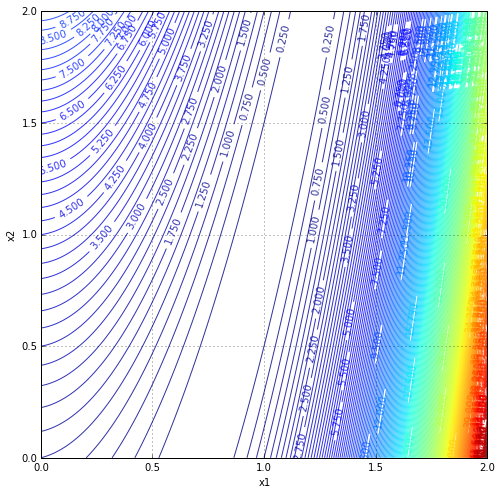

In [91]:
x1 = linspace(0, 2, 500)
x2 = linspace(0, 2, 500)
xx1, xx2 = meshgrid(x1, x2)

f = 0.25*(xx1 - 1)**2 + (2*xx1**2 - xx2 - 1)**2

constr3 = (xx2 <= -5)

figure(figsize=(8, 8))
grid(True)
xlabel('x1')
ylabel('x2')

CS = contour(x1, x2, f, 200, alpha=0.8)
plt.clabel(CS, CS.levels)
#contourf(x1, x2, constr1, 1, alpha=0.5, linewidths=4, cmap='autumn')

## Метод градиентного спуска

In [92]:
def gradient_descent(x0, func, x_true, f_true, grad_func, check_difference, step, tol, max_time=10):
    start = time.time()
    x = np.array(x0)
    i = 0
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        if (i % 100 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1]]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1]]
        
        x -= step * grad_func(x)
        i += 1

In [93]:
#print gradient_descent(x, func, x_true, f_true, grad_func, check_difference, 0.01, 10 ** (-6))

## Метод сопряженных градиентов

In [94]:
def conjugate_gradient(x0, func, x_true, f_true, grad_func, check_difference, tol, max_time=10):
    start = time.time()
    x = np.array(x0)
    i = 0
    S = -grad_func(x)
    new_grad = -S
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        
        if (i % 100 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1]]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1]]
        def func_lambd(lambd):
            return func(x + lambd * S)
        prev_grad = new_grad
        lambd = opt.minimize(func_lambd, 0.0, method='Powell').x
        x += lambd*S
        new_grad = grad_func(x)
        w = np.linalg.norm(new_grad)**2 / np.linalg.norm(prev_grad)**2
        S = -new_grad + w*S
        i += 1

In [163]:
print conjugate_gradient(x, func, x_true, f_true, grad_func, check_difference, 10 ** (-6), 1)

[1, array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.00000001,  1.        ,
        0.99999999,  0.99999999,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  

## Метод наискорейшего спуска

In [96]:
def optimal_gradient_descent(x0, func, x_true, f_true, grad_func, check_difference, tol, max_time=10):
    start = time.time()
    x = np.array(x0)
    i = 0
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        if (i % 100 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1]]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1]]
        
        S = -grad_func(x)
        def func_lambd(lambd):
            return func(x + lambd * S)
        lambd = opt.minimize(func_lambd, 0.0, method='Powell').x
        x += lambd*S
        i += 1

In [97]:
#print optimal_gradient_descent(x, func, x_true, f_true, grad_func, check_difference, 10 ** (-8), 10)

## Метод Ньютона

In [201]:
def newton_method(x0, func, x_true, f_true, grad_func, hess_func, check_difference, tol, max_time=10):
    start = time.time()
    x = np.array(x0)
    i = 0
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        if (i % 100 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1]]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1]]
        micro_step = 0.001
        S = grad_func(x)
        H = hess_func(x)
        res = H.I * np.matrix(S).T
        x -= np.asarray(res).ravel()
        i += 1

In [100]:
#print newton_method(x, func, x_true, f_true, grad_func, hess_func, check_difference, 10 ** (-2), 1)

## Напишем тестирующую функцию, принимающую максимальное время работы

In [109]:
def test_method(method, dimension=2, x_true=x_true, f_true=f_true, func=func, grad_func=grad_func, hess_func=hess_func, check_difference=check_difference, tol=10**(-8), max_time=10):
    cur_dimension = dimension
    
    x = [-1.5] + [1.0]*(cur_dimension - 1)
    x_true = [1.0] * cur_dimension
    f_true = 0.0
    
    res = method(cur_dimension, func, grad_func, hess_func, check_difference, tol, max_time)
    

## Научимся генерировать "портящую" матрицу $P$. 

Нам нужна положительно определенная плохо обусловленная матрица с $\frac{\lambda_{max}}{\lambda_{min}} \sim 10^6$.

Создадим диагональную матрицу $D$, такую что $\frac{\max{D_{ii}}}{\min{D_{ii}}} \sim 10^6$. Затем умножим её на слева на $V$ и справа на $V^T$, где $V^T = V^{-1}$ - ортогональная матрица.

Ортогональную матрицу получим из QR разложения рандомной матрицы на ортогональную и верхнетреугольную.

После всего этого получим матрицу $P = VDV^T$, удовлетворяющую необходимым свойствам.

In [195]:
np.random.seed(2)
temp = np.random.randn(10000).reshape((100, 100))
Q, R = np.linalg.qr(temp)
P = Q.T.dot(np.diagflat([10**6] + [1]*99)).dot(Q)

## Создадим вспомогательные функции для второй части

$$ f(x) = \sum\limits_{i=1}^n e^{-x_i} + e^{\sum x_i - 1} $$

$$ \frac{\partial f}{\partial x_i} = - e^{-x_i} + e^{\sum x_i - 1} $$

$$ \frac{\partial^2 f}{\partial x_i \partial x_j} = e^{-x_i} \delta_{ij} + e^{\sum x_i - 1} $$

$$x_{i}^{opt} = \frac{1}{n+1}$$

$$f(x_{opt}) = (n+1) e^{- \frac{1}{n+1}}$$

In [208]:
def func2(x):
    return np.sum(np.power(np.e, -x)) + np.power(np.e, np.sum(x) - 1)

def bad_func2(x):
    return func2(P.dot(x))

def grad_func2(x):
    return - np.power(np.e, -x) + np.power(np.e, np.sum(x) - 1)

def bad_grad_func2(x):
    return P.dot(grad_func2(P.dot(x)))

def hess_func2(x):
    return np.matrix(np.diagflat(np.power(np.e, -x)) + np.power(np.e, np.sum(x) - 1))

def opt_x(dimension):
    return np.array([1.0 / (dimension+1)] * dimension)

def opt_func2(dimension):
    return func2(opt_x(dimension))

In [238]:
dimension2 = 100
x2 = np.array(-np.random.randn(100)) / 1e7
bad_x2 = P.dot(x2)
bad_x2_opt = np.linalg.inv(P).dot(opt_x(100))
bad_func2_opt = bad_func2(bad_x2_opt)
print bad_x2.shape

(100,)


In [220]:
#print conjugate_gradient(x2, func2, opt_x(100), opt_func2(100), grad_func2, check_difference, 10 ** (-6), 1)

In [221]:
#print gradient_descent(x2, func2, opt_x(100), opt_func2(100), grad_func2, check_difference, 0.01, 10 ** (-6), 30)

In [222]:
#print optimal_gradient_descent(x2, func2, opt_x(100), opt_func2(100), grad_func2, check_difference, 10 ** (-6), 30)

In [223]:
#print newton_method(x2, func2, opt_x(100), opt_func2(100), grad_func2, hess_func2, check_difference, 10 ** (-6), 30)

In [234]:
def conjugate_gradient(x0, func, x_true, f_true, grad_func, check_difference, tol, max_time=10):
    start = time.time()
    x = np.array(x0)
    i = 0
    S = -grad_func(x)
    new_grad = -S
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        
        if (i % 100 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1]]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1]]
        def func_lambd(lambd):
            return func(x + lambd * S)
        prev_grad = new_grad
        lambd = opt.minimize(func_lambd, 0.0, method='Powell').x
        x += lambd*S
        new_grad = grad_func(x)
        w = np.linalg.norm(new_grad)**2 / np.linalg.norm(prev_grad)**2
        S = -new_grad + w*S
        i += 1

In [232]:
print grad_func2(P.dot(x2))

[-0.63215005 -0.63215752 -0.63218387 -0.63217028 -0.63218047 -0.63216919
 -0.63215709 -0.63216318 -0.63216962 -0.63217218 -0.63216564 -0.63219003
 -0.6321583  -0.6321492  -0.63216729 -0.63214008 -0.63215431 -0.63216634
 -0.63214763 -0.6321586  -0.63215752 -0.63215223 -0.63216011 -0.63216832
 -0.63214643 -0.63214537 -0.63216476 -0.63217141 -0.63216126 -0.63216894
 -0.63214982 -0.63218084 -0.63212807 -0.63216474 -0.63215826 -0.63214016
 -0.63214065 -0.63215043 -0.63215459 -0.63215213 -0.63215474 -0.63216968
 -0.63213046 -0.63214022 -0.6321358  -0.63214738 -0.63216075 -0.63215369
 -0.63216909 -0.63217212 -0.63216457 -0.63216231 -0.63216077 -0.63215223
 -0.63215174 -0.6321611  -0.63217784 -0.63212799 -0.63215361 -0.63214265
 -0.63215564 -0.63215133 -0.63214717 -0.6321461  -0.63213279 -0.6321528
 -0.63215928 -0.63218621 -0.63215796 -0.63216456 -0.63216136 -0.63215908
 -0.6321531  -0.63216713 -0.63214007 -0.63215692 -0.63216878 -0.63213984
 -0.63216744 -0.63214974 -0.63215447 -0.63217189 -0.

In [240]:
print conjugate_gradient(x2, bad_func2, bad_x2_opt, bad_func2_opt, bad_grad_func2, check_difference, 10 ** (-6), 1)

[0, array([ -9.83301836e-08,  -3.75758201e-08,  -1.17636152e-08,
         5.61144223e-08,   2.37674786e-07,   1.06548531e-07,
         1.17557635e-07,   9.51865917e-09,  -7.15566907e-09,
         7.12758220e-08,  -2.86841146e-08,   1.72868876e-08,
         7.74339746e-09,  -1.29208162e-07,   4.84490009e-08,
        -1.29248624e-08,  -1.12000033e-07,  -9.22197599e-08,
         7.52596970e-08,  -1.19226348e-07,  -2.53577800e-07,
         2.56797705e-08,  -1.82744565e-07,  -1.67419388e-07,
        -1.47338033e-07,   1.70470671e-08,  -2.29339791e-07,
        -8.38143486e-08,   1.31795424e-08,   3.20692059e-08,
         2.71315926e-09,   2.44584769e-07,   5.05161049e-08,
        -8.12387383e-08,  -2.59480071e-08,  -2.01854643e-08,
         2.59399534e-08,   9.25636745e-08,  -3.02669339e-08,
         1.94668171e-07,  -4.85359952e-09,  -7.41495483e-08,
        -1.25482677e-07,  -9.64405658e-08,  -4.50733035e-08,
        -1.67532962e-08,  -3.00695231e-07,   2.19775526e-07,
         4.52172396e

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app
